*Author: Jiayan Li*

This project focuses on meta-algorithms: S-learners, T-learners, and X-learners. The base learner used here is the Decision Tree Regressor from the `scikit-learn` Python library. It can easily be swapped for another machine learning algorithm. Most of the ideas in this project are inspired by the paper ["Metalearners for Estimating Heterogeneous Treatment Effects Using Machine Learning"](https://www.pnas.org/doi/suppl/10.1073/pnas.1804597116) by Kunzel et al. (2019), which proposes X-learners, and its appendix.


# Introduction

To reveal the impact of a certain treatment, ideally we want to have the individual treatment effects (ITEs, denoted as $D_i$ for the $i$ th unit). 

$D_i := Y_i(1) - Y_i(0)$

However, in reality, we can never observe ITEs because the individual is only observed either under treatment or control, not under both. The goal is to estimate the ITEs using the observed data.

It's useful to define the following annotations:
- $Y_i(1)$: the potential outcome of unit $i$ under treatment, $Y_i(1) \in \mathbb{R}$;
- $Y_i(0)$: the potential outcome of unit $i$ under control, $Y_i(0) \in \mathbb{R}$;
- $X_i$: the covariates of unit $i$, $X_i \in \mathbb{R}^d$ is a $d$-dimensional vector;
- $W_i$: the treatment indicator of unit $i$, $W_i \in \{0, 1\}$;
- $\mu_1(x) = \mathbb{E}[Y(1) \mid X = x]$: response under treatment conditioned on covariates;
- $\mu_0(x) = \mathbb{E}[Y(0) \mid X = x]$: response under control conditioned on covariates.


To approximate the ITE, we will estimate the conditional average treatment effect (CATE) defined as $\tau(x) := \mathbb{E}[D \mid X = x] = \mathbb{E}[Y(1) - Y(0) \mid X = x]$

Metalearners are a combination of base learners (supervised learning algorithms). Metalearners for the CATE have the adavantage of flexibility to capture complex relationships between the covariates and the potential outcomes, because they allow base learners to take any form.

In [ ]:
!pip install pandas numpy matplotlib scikit-learn

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# manually defined functions
from utils import *

# Step 1: Data Generation Process (DGP) for the simulations

In [3]:
# Set the random seed for reproducibility
np.random.seed(42)

# Generate sample size
n = 5000

# Generate features
age = np.random.randint(18, 65, n)
income = np.random.normal(50000, 10000, n)
gender = np.random.choice(['Male', 'Female'], n)
loyalty_program = np.random.choice(['Yes', 'No'], n, p=[0.4, 0.6])

# Define confounders that have no direct influence on the outcome
confounder_1 = np.random.choice(['TypeA', 'TypeB', 'TypeC'], n)
confounder_2 = np.random.normal(0, 1, n)

# Define treatment assignment probabilities based on features
prob_treatment = 0.2 + 0.1 * (age > 40) + 0.1 * (income > 60000) + 0.1 * (gender == 'Female') + 0.2 * (loyalty_program == 'Yes')

# Add small perturbations (random noise/errors) to treatment probabilities
prob_treatment += np.random.normal(0, 0.02, n)

# Adjust probabilities to achieve the desired treatment proportion
# Here, we want the treatment group to be 10% of the total sample
adjustment_factor = 0.1 / prob_treatment.mean()
prob_treatment *= adjustment_factor
# Ensure probabilities are between 0 and 1
prob_treatment = np.clip(prob_treatment, 0, 1)  

# Assign treatment based on probabilities
treatment = np.random.binomial(1, prob_treatment)

# Define potential outcomes based on features and treatment
# Effect of control
y0 = 10 + 0.01 * age + 0.00005 * income - 2 * (gender == 'Female') + 5 * (loyalty_program == 'Yes') + np.random.normal(0, 1, n)
# Effect of treatment
y1 = 15 + 0.02 * age + 0.00008 * income + 2 * (gender == 'Female') + 8 * (loyalty_program == 'Yes') + np.random.normal(0, 1, n)

# Assign observed outcomes based on treatment
y = treatment * y1 + (1 - treatment) * y0

# Calculate the true CATE for each individual
# These values are never identifiable in practice
true_cate = y1 - y0

# Create a DataFrame
data = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Gender': gender,
    'LoyaltyProgram': loyalty_program,
    'Confounder1': confounder_1,
    'Confounder2': confounder_2,
    'Treatment': treatment,
    'Outcome': y,
    'TrueCATE': true_cate
})

# Print the first few rows of the generated data
print(data.head())

   Age        Income  Gender LoyaltyProgram Confounder1  Confounder2  \
0   56  51448.878331    Male             No       TypeB     0.596102   
1   46  50239.030433  Female             No       TypeC    -0.589140   
2   32  46485.857643  Female             No       TypeB     0.735601   
3   60  65634.133588    Male             No       TypeB    -0.214352   
4   25  41815.713341  Female            Yes       TypeC     1.293024   

   Treatment    Outcome   TrueCATE  
0          0  12.681115   6.287117  
1          0  11.158464  10.006634  
2          0   9.234394  11.447393  
3          0  14.831519   5.855011  
4          1  28.806031  13.878352  


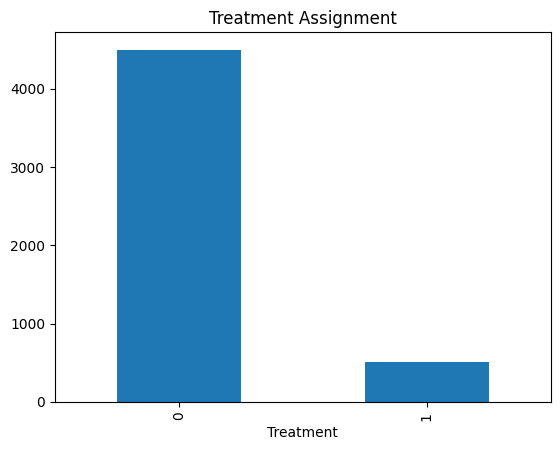

In [4]:
# plot the Treatment column
data['Treatment'].value_counts().plot(kind='bar', title='Treatment Assignment');

Data Engineering

In [5]:
# convert categorical variables Gender and LoyaltyProgram to one-hot-encoded variables
# 1 indicates positive, 0 indicates negative
data = pd.get_dummies(data, columns=['Gender', 'LoyaltyProgram', 'Confounder1'], drop_first=True, dtype=int)

# Step 2: Implementing T-, S-, and X-learners

The base learner used in this project is the Decision Tree Regressor. We will implement the T-, S-, and X-learners using this base learner.

## T-learner (Two Model Learner):

The T-learner involves training two separate models: one for the treated group and one for the control group. The ITE is estimated as the difference between the predictions of these two models.

1. First, we fit 
    - a base learner using the obersvations under control $\{(X_i, Y_i)\}_{W_i=0}$ and obtain the predicted outcomes $\hat{\mu}_0(x)$.
    - a base learner using the obersvations under treatment $\{(X_i, Y_i)\}_{W_i=1}$ and obtain the predicted outcomes $\hat{\mu}_1(x)$.

2. The CATE is then calculated as $\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$.

For a tree model specifically, we split the data into two groups based on the treatment status and fit a decision tree to each group. The CATE is then calculated as the difference between the predicted outcomes from the two trees.

<img src="T-learner.png" alt="T-learner" width="300"/>

Step 1: fit a model to the control group and a model to the treated group.

In [6]:
# split the data into treatment and control groups
data_treatment = data[data['Treatment'] == 1]
data_control = data[data['Treatment'] == 0]

In [7]:
# split the data into training and validation sets
# note that here we are dropping the Treatment column
X_train_t, X_val_t, y_train_t, y_val_t = split_data(data_treatment, drop_treatment=True)
X_train_c, X_val_c, y_train_c, y_val_c = split_data(data_control, drop_treatment=True)

In [ ]:
# fit a decision tree regressor to the training data 
# and select the best hyperparameters (max_depth, min_sample_split) using the validation data
results_t = fit_val_model(X_train_t, y_train_t, X_val_t, y_val_t)
print(f"validation results for treatment group:")
print(results_t)

results_c = fit_val_model(X_train_c, y_train_c, X_val_c, y_val_c)
print(f"validation results for control group:")
print(results_c)

Here, ```model_c``` estimates the treatment response function $\mu_0(x) = \mathbb{E}[Y(0) \mid X =x ]$, and ```model_t``` estimates the control response function $\mu_1(x) = \mathbb{E}[Y(1) \mid X =x ]$.

In [9]:
# retrain the model using the best hyperparameters
# trained model for control group
model_c = retrain_best_model(results_c, X_train_c, y_train_c, X_val_c, y_val_c)

# trained model for treatment group
model_t = retrain_best_model(results_t, X_train_t, y_train_t, X_val_t, y_val_t)

Step 2: we feed all the data points into both models $\hat{\mu_0}(x)$ and $\hat{\mu_1}(x)$ to get the respective predicted outcomes and then compute the difference to estimate the treatment effect for each individual.

In [10]:
# get a copy of the original data
data_t_learn = data.copy()

# Predict the control and treatment outcomes
X = data_t_learn.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1)
data_t_learn['ControlOutcome'] = model_c.predict(X)
data_t_learn['TreatmentOutcome'] = model_t.predict(X)

# Calculate the CATE
data_t_learn['PredictedCATE'] = data_t_learn['TreatmentOutcome'] - data_t_learn['ControlOutcome']

# Calculated the difference between the predicted and true CATE
data_t_learn['CATEError'] = data_t_learn['PredictedCATE'] - data_t_learn['TrueCATE']

# data_t_learn.head()

In [11]:
print(f"Mean squared error of the predicted CATE: {np.mean(data_t_learn['CATEError'] ** 2)}")

Mean squared error of the predicted CATE: 2.2471883926671237


## S-learner (Single Model Learner):

The S-learner uses a single machine learning model to estimate the treatment effect. It includes the treatment indicator as an additional feature in the model.

The biggeset difference between T- and S-learner is that in S-learner the treatment indicator is included as a 0, 1-valued feature similar to all of the other features, and only one model is trained on the entire dataset. 

We estimate the combined response function $\mu(x, w) = \mathbb{E}[Y^{obs} \mid X = x, W = w]$. The CATE is then calculated as $\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)$.

For a tree model specifically, 

1. First, we fit a base learner to the entire dataset with the treatment status as an additional feature $M(Y ∼ (X, W))$.
2. The CATE is then calculated as $\hat{\tau}(x) = M(Y ∼ (X, W = 1)) - M(Y ∼ (X, W = 0))$.


<img src="S-learner.png" alt="S-learner" width="300"/>

Step 1: Fit a single model to the entire dataset, including the treatment indicator as a feature

In [12]:
# get a copy of the original data
data_s_learn = data.copy()

# split the data into training and validation sets
# note that here we are keeping the Treatment column
X_train, X_val, y_train, y_val = split_data(data_s_learn, drop_treatment=False)

# find the best hyperparameters for the model using the validation set
results = fit_val_model(X_train, y_train, X_val, y_val)

# retrain the model using the best hyperparameters and full data
model = retrain_best_model(results, X_train, y_train, X_val, y_val)

Step 2: Pretend that all individuals are in treated or control group, and calculate the treatment effect for each individual.

In [13]:
# pretend treatment=1 for all individuals
X = data_s_learn.drop(['Outcome', 'TrueCATE'], axis=1)

# modify the Treatment column to be all 1s
X['Treatment'] = 1
# get the predicted outcomes if everyone was treated
data_s_learn['PredictedOutcomeTreated'] = model.predict(X)

# using the same procedure as before, pretend treatment=0 for all individuals
X['Treatment'] = 0
data_s_learn['PredictedOutcomeControl'] = model.predict(X)

In [14]:
# calculate the predicted CATE
data_s_learn['PredictedCATE'] = data_s_learn['PredictedOutcomeTreated'] - data_s_learn['PredictedOutcomeControl']

# calculate the difference between the predicted and true CATE
data_s_learn['CATEError'] = data_s_learn['PredictedCATE'] - data_s_learn['TrueCATE']

# data_s_learn.head()

In [15]:
# calculate the mean squared error of the predicted CATE
print(f"Mean squared error of the predicted CATE: {np.mean(data_s_learn['CATEError'] ** 2)}")

Mean squared error of the predicted CATE: 2.171772563379486


Compared to the T-learner, the S-learner has the advantage of simplicity and efficiency in small samples:

1. Since it uses a single model, it is simpler to implement and manage.
2. Efficiency in Small Samples: It may perform better in small sample sizes because all data (treated and control) are used to train a single model.


## X-learner (Cross-learner):

The X-learner is a meta-learner approach that refines the T-learner by incorporating a two-stage process. First, it estimates the treatment effects for each group separately, and then it combines these estimates to improve the overall estimation.

1. First, same as T-learner, we fit two base learners to estimate the treatment effect for each group:
    - Fit a base learner to the treated group to estimate the treatment effect $\hat{\mu}_1(x)$.
    - Fit a base learner to the control group to estimate the treatment effect $\hat{\mu}_0(x)$.

2. Next, we compute the residuals for each group:
    - For the treated group, we calculate the residuals as $\tilde{D_i^1} = Y_i^1 - \hat{\mu}_1(X_i)$.
    - For the control group, we calculate the residuals as $\tilde{D_i^0} = \hat{\mu}_0(X_i)- Y_i^0$.

3. We then fit two additional base learners to predict the residuals:
    - Fit a base learner to the treated group residuals to estimate the residual function $\hat{\tau}_1(x)$.
    - Fit a base learner to the control group residuals to estimate the residual function $\hat{\tau}_0(x)$.

4. Finally, we combine the residual functions with weighting function $g(x)$ to estimate the CATE:
    - $\hat{\tau}(x) = g(x) \cdot \hat{\tau}_0(x) + (1 - g(x)) \cdot \hat{\tau}_1(x)$.

In [16]:
# split the data into treatment and control groups
data_treatment = data[data['Treatment'] == 1]
data_control = data[data['Treatment'] == 0]

For step 1: 

recall that we've fit two models for the T-learner, one for the treatment group and one for the control group. Because the first stage of X-learner is the same as T-learner, we can reuse the models we've already trained.

In [17]:
# feed the treatment group data to the control group model
X_t = data_treatment.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1)
data_treatment.loc[:, 'PredictedOutcomeControl'] = model_c.predict(X_t)

# feed the control group data to the treatment group model
X_c = data_control.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1)
data_control.loc[:, 'PredictedOutcomeTreated'] = model_t.predict(X_c)

Step 2: get the residuals for each group

In [18]:
# compute the residuals
data_treatment.loc[:, 'Residual'] = data_treatment.loc[:, 'Outcome'] - data_treatment.loc[:, 'PredictedOutcomeControl']
data_control.loc[:, 'Residual'] = data_control.loc[:, 'PredictedOutcomeTreated'] - data_control.loc[:, 'Outcome']

Step 3: we fit two additional models to predict the residuals. Here, we use linear regression models to predict the residuals.

In [19]:
# Fit a model to predict residuals in the treatment group
model_t_residual = LinearRegression()
model_t_residual.fit(data_treatment.drop(['Treatment', 'Outcome', 'TrueCATE', 'Residual', 'PredictedOutcomeControl'], axis=1), 
                     data_treatment['Residual'])

# Fit a model to predict residuals in the control group
model_c_residual = LinearRegression()
model_c_residual.fit(data_control.drop(['Treatment', 'Outcome', 'TrueCATE', 'Residual', 'PredictedOutcomeTreated'], axis=1), 
                     data_control['Residual'])

LinearRegression()

In [20]:
# Get a copy of the original data
data_x_learn = data.copy()

# Predict the control and treatment outcomes
data_x_learn['TreatmentOutcome'] = model_t_residual.predict(data.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1))
data_x_learn['ControlOutcome'] = model_c_residual.predict(data.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1))

Last Step: Get the weights $g(x)$ by fitting a classifier to predict the treatment status based on the covariates

In [21]:
# Prepare the data
X = data.drop(['Treatment', 'Outcome', 'TrueCATE'], axis=1)
y = data['Treatment']

# Fit the logistic regression model
propensity_model = LogisticRegression()
propensity_model.fit(X, y)

# Predict the propensity scores
data_x_learn['PropensityScore'] = propensity_model.predict_proba(X)[:, 1]

In [22]:
# calculate the weighted average of the predicted treatment and control outcomes as the predicted outcome
data_x_learn['PredictedCATE'] = data_x_learn['PropensityScore'] * data_x_learn['TreatmentOutcome'] \
                                + (1 - data_x_learn['PropensityScore']) * data_x_learn['ControlOutcome']

In [23]:
# Calculate the difference between the predicted and true CATE
data_x_learn['CATEError'] = data_x_learn['PredictedCATE'] - data_x_learn['TrueCATE']

# data_x_learn.head()

In [24]:
print(f"Mean squared error of the predicted CATE: {np.mean(data_x_learn['CATEError'] ** 2)}")

Mean squared error of the predicted CATE: 1.9858740420810286


# Summary

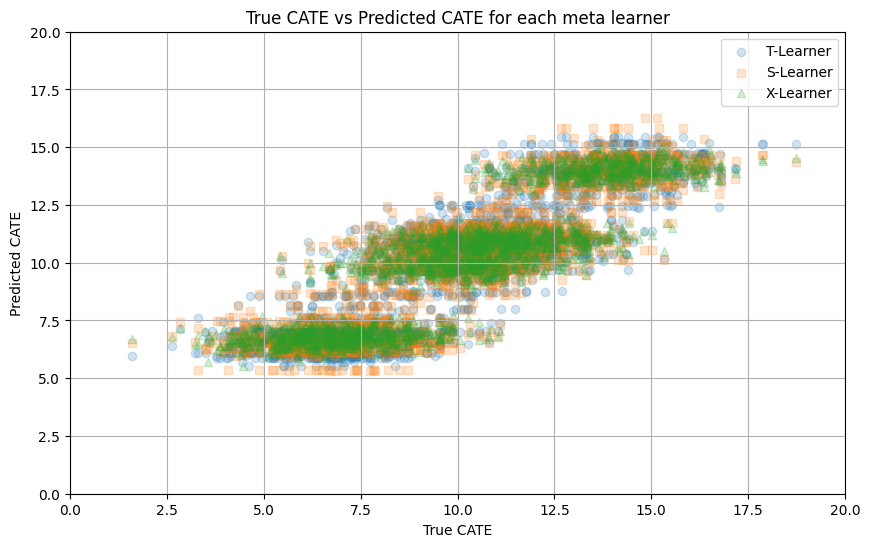

,MSE,Bias,Variance
T-Learner,2.247188,-0.000544,2.247188
S-Learner,2.171773,0.017067,2.171481
X-Learner,1.985874,-0.003461,1.985862


In [25]:
result_summary(data, 
               data_t_learn, 
               data_s_learn, 
               data_x_learn, 
               plot=True,)

From the simulation results, we observe that the X-learner outperforms both the S-learner and the T-learner in terms of predictive accuracy. This is evident from the lower mean squared error (MSE) associated with the X-learner compared to the other two methods.

## Evaluation Metrics

Mean Squared Error (MSE):

The MSE is a common metric used to evaluate the performance of a regression model. It measures the average squared difference between the observed actual outcomes and the outcomes predicted by the model. A lower MSE indicates a better fit to the data. In our results, the X-learner achieves the lowest MSE, indicating that its predictions are closest to the true conditional average treatment effect (CATE).

Bias 

Bias measures the error introduced by approximating a real-world problem, which may be complex, by a simplified model. The bias values for all learners are very close to zero, indicating that the models do not consistently overestimate or underestimate the true CATE.

Variance

This measures how much the model's predictions would vary if it were trained on different data. The X-learner has the lowest variance, suggesting that it produces more stable predictions across different samples.


## Experimentation

Note that the data we generated for the simulations above has a moderate sample size and is moderately unbalanced, with 0.1% of the data points being treated.

In the simulation, we can change the sample size and proportion of sample under treatmen to observe their impact on the performance of the T-, S-, and X-learners. 

To save space, I wrote the above-written code in a single function that generates the data, trains the models, and evaluates their performance.

### Small sample size + balanced treatment assignment: 

In this case, the T-learner may perform better than the S-learner because it can specialize in each subgroup. The X-learner may also perform well by combining the estimates from the T-learner.

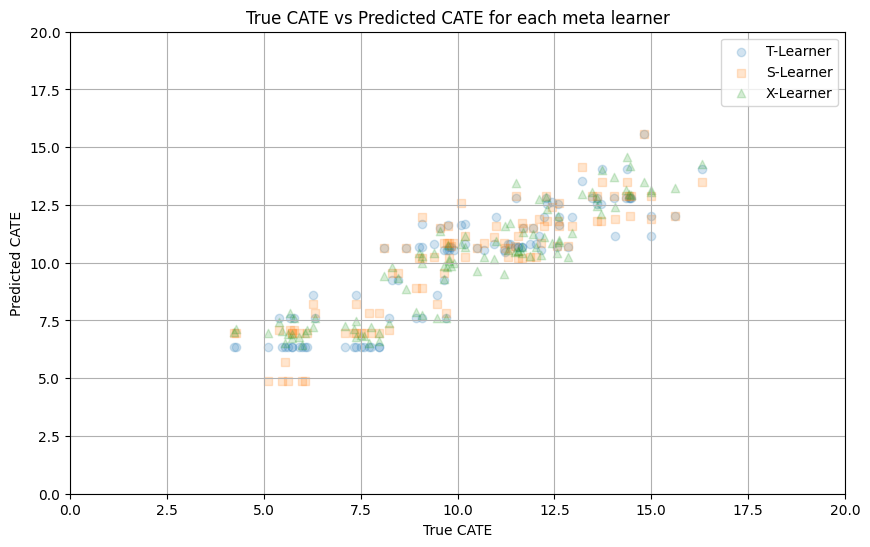

,MSE,Bias,Variance,SampleSize,TreatmentProportion
T-Learner,1.981167,-0.052943,1.978364,200,0.5
S-Learner,1.997690,-0.078547,1.991520,200,0.5
X-Learner,1.719022,-0.074419,1.713483,200,0.5


In [26]:
main(n=200, treatment_proportion=0.5, plot=True)

### Large sample size + unbalanced treatment assignment: 

In this case, the S-learner may perform better than the T-learner because it uses all the data to train a single model. The X-learner may also perform well by combining the estimates from the T-learner.

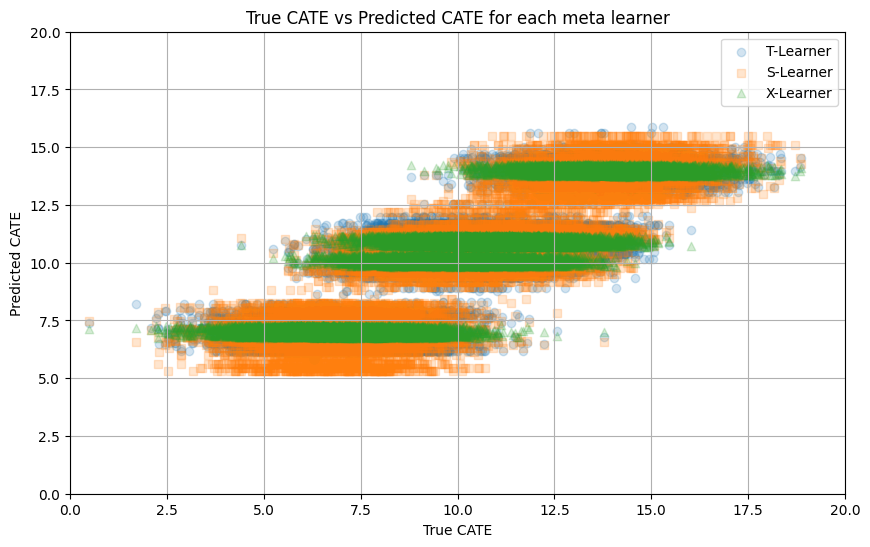

,MSE,Bias,Variance,SampleSize,TreatmentProportion
T-Learner,2.353644,0.103101,2.343014,50000,0.01
S-Learner,2.319107,0.053648,2.316229,50000,0.01
X-Learner,2.189331,0.101198,2.179090,50000,0.01


In [27]:
main(n=50000, treatment_proportion=0.01, plot=True)

## Analysis of Each Meta-Learner

S-Learner:
The S-learner treats the treatment indicator as an additional feature in a single model. This simplicity makes the S-learner computationally efficient and easy to implement. However, its simplicity can be a drawback when dealing with complex interactions between features and treatment effects. It assumes that the same model can capture both the treatment and control effects, which may not always be true. Despite its simplicity, the S-learner performs well in our simulations but is outperformed by the more sophisticated X-learner.

T-Learner:
The T-learner fits separate models for the treatment and control groups. This approach allows it to capture heterogeneous treatment effects more effectively, as it can model the treatment and control outcomes independently. However, this separation can lead to inefficiencies, especially with smaller datasets, as each model only uses a subset of the data. The T-learner performs adequately but has a higher MSE compared to the X-learner, indicating less accurate predictions.

X-Learner:
The X-learner is an advanced meta-learner that combines the strengths of both the S-learner and T-learner. It first estimates the treatment effects separately (like the T-learner) and then uses these estimates to refine the treatment effect predictions using the control and treated data (like the S-learner). This iterative approach helps in reducing bias and variance, leading to more accurate and robust predictions. The X-learner's ability to handle complex data structures and interactions makes it particularly effective in scenarios with imbalanced data or when the treatment effects vary significantly across different subgroups.

# Conclusion

The performance of meta-learners depends heavily on the structure and complexity of the data. The X-learner, with its combination of the strengths of both S- and T-learners, provides a balanced approach that results in higher accuracy and robustness. It is particularly well-suited for datasets with complex treatment interactions and varying sample sizes. However, for smaller datasets or less complex scenarios, the S-learner may offer sufficient performance with lower computational cost. The T-learner, while effective for heterogeneous treatment effects, requires careful consideration of data availability and model complexity.